<a href="https://colab.research.google.com/github/Edna-cyber/telepresence/blob/main/3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import cv2
from PIL import Image
import numpy as np
import sys
import torch
import matplotlib.pyplot as plt

In [3]:
# code for installing pytorch3d inside Google Colab
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
!pip install fvcore iopath
!pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 857.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=0ee970a30cbfd628af48208e2cd78dcdd403489c50493c86dd65428c4c7d0daa
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=b6946ec7978f584154a784c7ae41927a07add2eb96a536debd99f2d08a132a3b
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu121_pyt210/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 173.1 MB/s eta 0:00:00


In [4]:
import pytorch3d
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointsRasterizationSettings,
    PointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
)
from pytorch3d.structures import Pointclouds

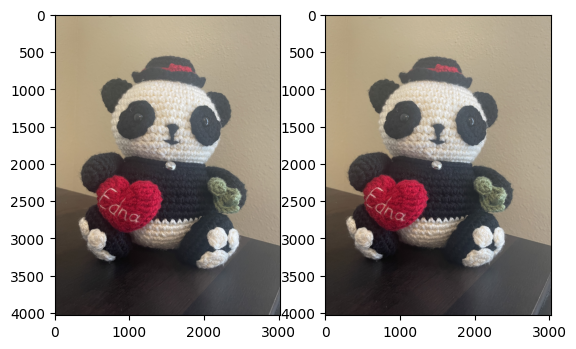

In [5]:
# Assuming that two frames of images are obtained from two adjacent cameras on the left and right
left_image = np.array(Image.open("/content/drive/MyDrive/Gaussian/panda_left.png"))
right_image = np.array(Image.open("/content/drive/MyDrive/Gaussian/panda_right.png"))

fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].imshow(left_image)
axs[1].imshow(right_image)

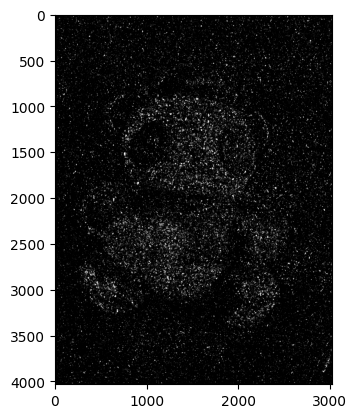

In [6]:
left_image_gray = cv2.cvtColor(left_image, cv2.COLOR_RGB2GRAY)
right_image_gray = cv2.cvtColor(right_image, cv2.COLOR_RGB2GRAY)
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(left_image_gray, right_image_gray)

plt.imshow(disparity, 'gray')
plt.show()

In [7]:
# image = Image.open("/content/drive/MyDrive/Gaussian/panda.png")
# image_np = np.array(image)
# image_normalized = image_np.astype(np.float32) / 255.0

In [8]:
f = 18000 # focal length in pixels, calculated from iphone data
baseline = 0.02 # meters
image_resolution = (3024, 4032)

In [9]:
def uv_to_xyz(u, v, d):
    """
    Convert 2D image coordinates (u, v) to 3D world coordinates (x, y, z).

    Parameters:
    - u, v: The 2D image coordinates.
    - f: The focal length of the camera in pixels.
    - d: The depth from the camera to the physical object.
    - principal_point: A tuple (u_0, v_0) representing the principal point of the camera (usually the image center).

    Returns:
    - A tuple (x, y, z) representing the 3D world coordinates.
    """
    h, w = image_resolution
    u_0, v_0 = h/2, w/2
    z = d
    x = (u-u_0)*z/f
    y = (v-v_0)*z/f
    return (x,y,z)

In [10]:
# Example usage
u, v = 700, 400 # example 2D image coordinates
d = 1
x, y, z = uv_to_xyz(u, v, d)
print(f"3D coordinates: x={x}, y={y}, z={z}")

3D coordinates: x=-0.04511111111111111, y=-0.08977777777777778, z=1


In [11]:
def twod_to_threed_lifting(f,disparity):
    h, w = image_resolution
    u_grid, v_grid = np.meshgrid(np.arange(h), np.arange(w))
    vectorized_func = np.vectorize(uv_to_xyz)
    d = f*baseline / disparity
    x, y, z = vectorized_func(u_grid, v_grid, d)
    threed_coordinates = np.stack((x, y, z), axis=-1)
    print(threed_coordinates.shape)
    print(threed_coordinates)
    return np.stack((x, y, z), axis=-1)

In [12]:
disparity

array([[-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16],
       ...,
       [-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16]], dtype=int16)

In [13]:
threed_coord = twod_to_threed_lifting(f,disparity)

<ipython-input-11-e2c9db31612d>:5: RuntimeWarning: divide by zero encountered in divide
  d = f*baseline / disparity
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in uv_to_xyz (vectorized)
  outputs = ufunc(*inputs)


(4032, 3024, 3)
[[[  1.89      2.52    -22.5    ]
  [  1.88875   2.52    -22.5    ]
  [  1.8875    2.52    -22.5    ]
  ...
  [ -1.88625   2.52    -22.5    ]
  [ -1.8875    2.52    -22.5    ]
  [ -1.88875   2.52    -22.5    ]]

 [[  1.89      2.51875 -22.5    ]
  [  1.88875   2.51875 -22.5    ]
  [  1.8875    2.51875 -22.5    ]
  ...
  [ -1.88625   2.51875 -22.5    ]
  [ -1.8875    2.51875 -22.5    ]
  [ -1.88875   2.51875 -22.5    ]]

 [[  1.89      2.5175  -22.5    ]
  [  1.88875   2.5175  -22.5    ]
  [  1.8875    2.5175  -22.5    ]
  ...
  [ -1.88625   2.5175  -22.5    ]
  [ -1.8875    2.5175  -22.5    ]
  [ -1.88875   2.5175  -22.5    ]]

 ...

 [[  1.89     -2.51625 -22.5    ]
  [  1.88875  -2.51625 -22.5    ]
  [  1.8875   -2.51625 -22.5    ]
  ...
  [ -1.88625  -2.51625 -22.5    ]
  [ -1.8875   -2.51625 -22.5    ]
  [ -1.88875  -2.51625 -22.5    ]]

 [[  1.89     -2.5175  -22.5    ]
  [  1.88875  -2.5175  -22.5    ]
  [  1.8875   -2.5175  -22.5    ]
  ...
  [ -1.88625  -2.5175 

In [14]:
# x,y,z,r,g,b
# far_lifted_coord = np.concatenate((far_threed_coord, image_normalized), axis=2)
# far_lifted_coord.shape

In [15]:
# close_lifted_coord = np.concatenate((close_threed_coord, image_normalized), axis=2)

In [16]:
def render(coord, image, device):
    # valid_mask = (depth > 0) & (depth < 1000)
    # valid_points = coord[valid_mask]
    points = torch.tensor(coord, dtype=torch.float32).view(-1,3).to(device)
    colors = torch.tensor(image, dtype=torch.float32).view(-1,3).to(device)

    # Create the Pointclouds object with points and their associated colors
    cloud = Pointclouds(points=[points], features=[colors])

    points = cloud.points_list()[0].cpu().numpy()  # Assuming you're working with the first point cloud
    colors = cloud.features_list()[0].cpu().numpy()  # Assuming RGB colors are used

    # Normalize colors to [0, 1] if they aren't already
    colors = colors - colors.min(0)
    colors = colors / colors.max(0)

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, marker='o')

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.title('Point Cloud Visualization')
    plt.show()

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

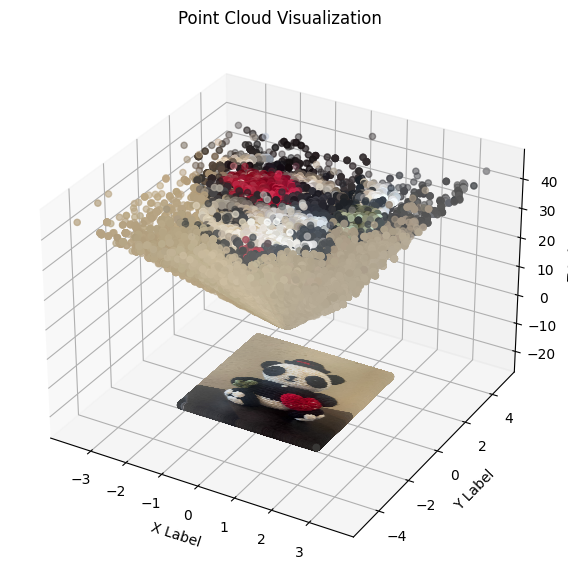

In [18]:
gt = render(threed_coord, left_image, device)